In [1]:
# Imports
# ---------

import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
from datetime import timezone

register_matplotlib_converters()

# File locations
# ----------------
data_home = './oxaria/raw/1oxaria/json/gap_filling/batch_3_jun21_oct21/'
pngs = './oxaria/pngs/gap_filling/'

In [2]:
# Load the df
# -------------
oxaria1_gases = pd.read_feather(
    data_home+'oxaria1_gases_gf_oct.ftr', use_threads=True).set_index(['tag', 'rec'])
oxaria1_gases.info()
oxaria1_gases_lt = oxaria1_gases.iloc[:, [0, 1, 2, 3, 16, 17, 18, 20]]
del oxaria1_gases

# Checking out the data types
# -----------------------------
oxaria1_gases_lt.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6803221 entries, ('scs-bgx-536', Timestamp('2021-06-01 00:00:06+0000', tz='UTC')) to ('scs-bgx-543', Timestamp('2021-09-30 23:59:58+0000', tz='UTC'))
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   val.no2.wev       float32
 1   val.no2.cnc       float32
 2   val.no2.aev       float32
 3   val.no2.wec       float32
 4   val.ox.wev        float32
 5   val.ox.cnc        float32
 6   val.ox.aev        float32
 7   val.ox.wec        float32
 8   val.no.wev        float32
 9   val.no.cnc        float32
 10  val.no.aev        float32
 11  val.no.wec        float32
 12  val.co.wev        float32
 13  val.co.cnc        float32
 14  val.co.aev        float32
 15  val.co.wec        float32
 16  val.sht.hmd       float32
 17  val.sht.tmp       float32
 18  exg.vb20.no2.cnc  float32
 19  insert_date       object 
 20  name              object 
dtypes: float32(19), object(2)
memory usage: 804.4+ MB

In [3]:
# Some cleaning incase have missed anything
#-------------------------------------------
oxaria1_gases_lt = oxaria1_gases_lt[~oxaria1_gases_lt.index.duplicated(keep='last')].reset_index()
oxaria1_gases_lt = oxaria1_gases_lt.dropna(axis=0,subset=['tag']).set_index(['tag','rec']).sort_index()

# Start and end dates of unstable operational periods

| Sensor tag         | Start               | End |
|-------------|---------------------|-----|
| scs-bgx-538 | 2021-01-28T00:00:00 | 2021-05-06T00:00:00 |
| scs-bgx-542 | 2021-01-27T12:00:00 | 2021-02-06T23:00:00 |
| scs-bgx-542 | 2021-04-19T09:00:00 | 2021-04-26T00:00:00 |
| scs-bgx-550 | 2021-03-10T12:00:00 | 2021-07-05T00:00:00 |
| scs-bgx-551 | 2021-01-01T00:00:00 | 2021-03-12T00:00:00 |
| scs-bgx-556 | 2021-02-09T12:00:00 | 2021-02-12T23:00:00 |


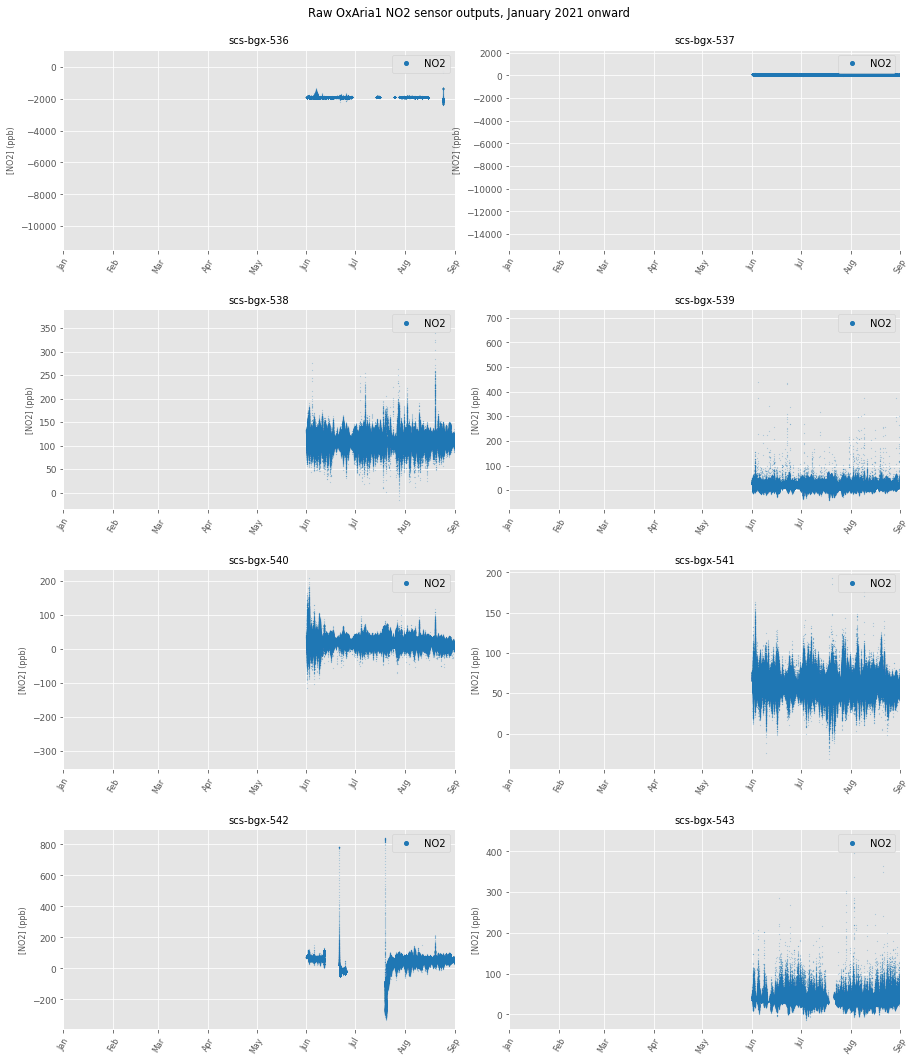

In [4]:
# Check on the outliers & start-ups in the original dataset
# ----------------------------------------------------------
plt.style.use('ggplot')
# plt.tight_layout()
myFmt = mdates.DateFormatter('%b')
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2021, 9, 1)

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False,
                         sharey=False, figsize=(15, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle('Raw OxAria1 NO2 sensor outputs, January 2021 onward',
             fontsize=11.5, y=0.91)

for tag, dat in oxaria1_gases_lt.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0, inplace=True)
    dat.plot(y='val.no2.cnc', c='tab:blue', linewidth=0.5, marker='o', ms=0.1, ls='', label='NO2', ax=ax, legend=True,
             zorder=1)
    ax.set_title(tag, fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=60,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.3)
    ax.legend(markerscale=40, frameon=True, framealpha=0.99, loc='upper right')

plt.show()

for ax in axes_list:
    ax.remove()

In [5]:
# Manually select each sensor with an issue then subset to remove the wonky data
# --------------------------------------------------------------------------------
s542 = oxaria1_gases_lt.reset_index().query('tag == "scs-bgx-542"').query(
    'rec <= "2021-06-10T00:00:00+0000" | rec > "2021-07-23T00:00:00+0000"')


# Sensors with no issues
# ------------------------
ok_tags = [
    'scs-bgx-536', 'scs-bgx-537', 'scs-bgx-538', 'scs-bgx-539', 'scs-bgx-540', 'scs-bgx-541',
    'scs-bgx-543'
]

# Select the sensor records with tags in this list
# --------------------------------------------------
sother = oxaria1_gases_lt.reset_index().query('tag in @ok_tags')

# Recombine
# -----------
oxaria1_gases_lt1 = pd.concat([sother, s542]).set_index(['tag', 'rec'])

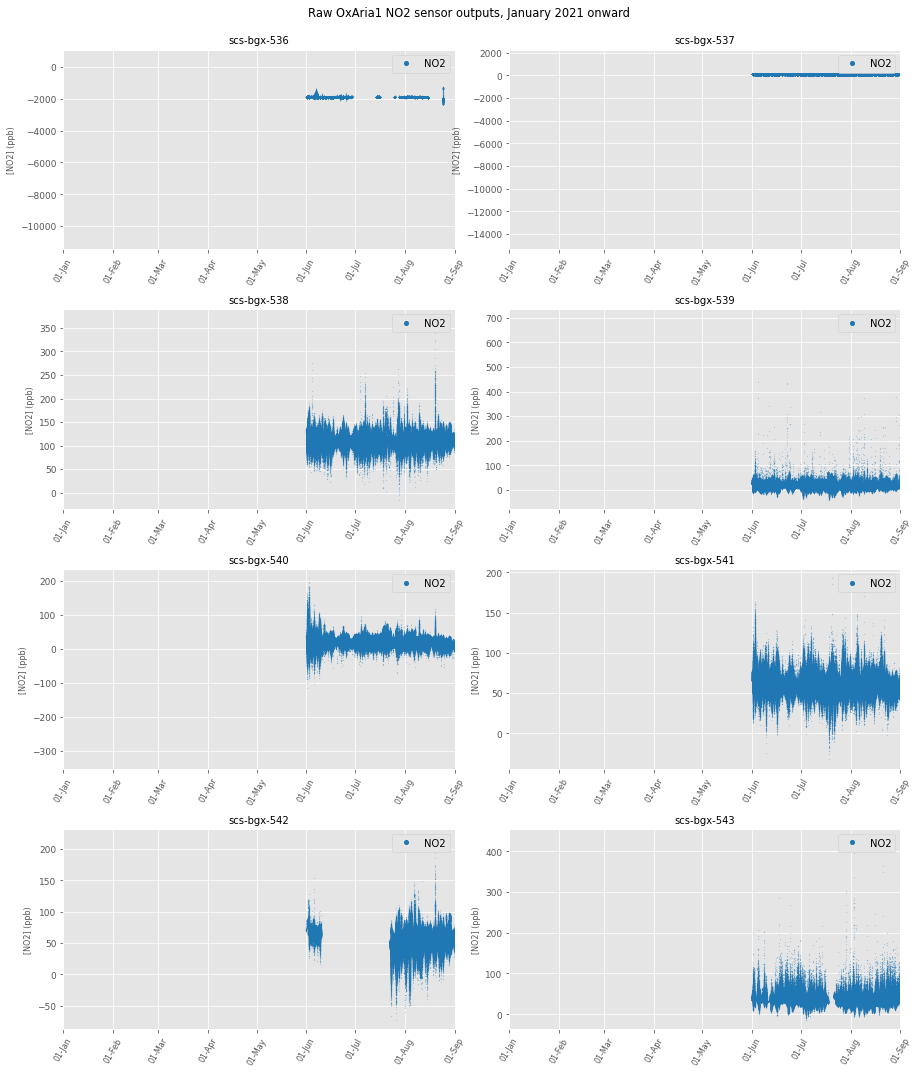

In [6]:
# Check on the outliers & start-ups in the filtered dataset
# ----------------------------------------------------------
plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2021, 9, 1)

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False,
                         sharey=False, figsize=(15, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle('Raw OxAria1 NO2 sensor outputs, January 2021 onward',
             fontsize=11.5, y=0.91)

for tag, dat in oxaria1_gases_lt1.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0, inplace=True)
    dat.plot(y='val.no2.cnc', c='tab:blue', linewidth=0.5, marker='o', ms=0.1, ls='', label='NO2', ax=ax, legend=True,
             zorder=1)
    ax.set_title(tag, fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=60,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.3)
    ax.legend(markerscale=40, frameon=True, framealpha=0.99, loc='upper right')

plt.show()

for ax in axes_list:
    ax.remove()

In [7]:
# Apply empirical filters
# -------------------------
cols = ['val.no2.cnc']

condition = ((oxaria1_gases_lt1['val.sht.tmp'] < -10.0) |
             (oxaria1_gases_lt1['val.sht.tmp'] > 35.0) |
             (oxaria1_gases_lt1['val.sht.hmd'] < 35.0))

for col in cols:
    oxaria1_gases_lt1[col +
                      '_1'] = np.where(condition, np.nan, oxaria1_gases_lt1[col])

# Save to feather
# -----------------
oxaria1_gases_lt1.reset_index().to_feather(
    data_home+'oxaria1_gases_stable_oct21.ftr')

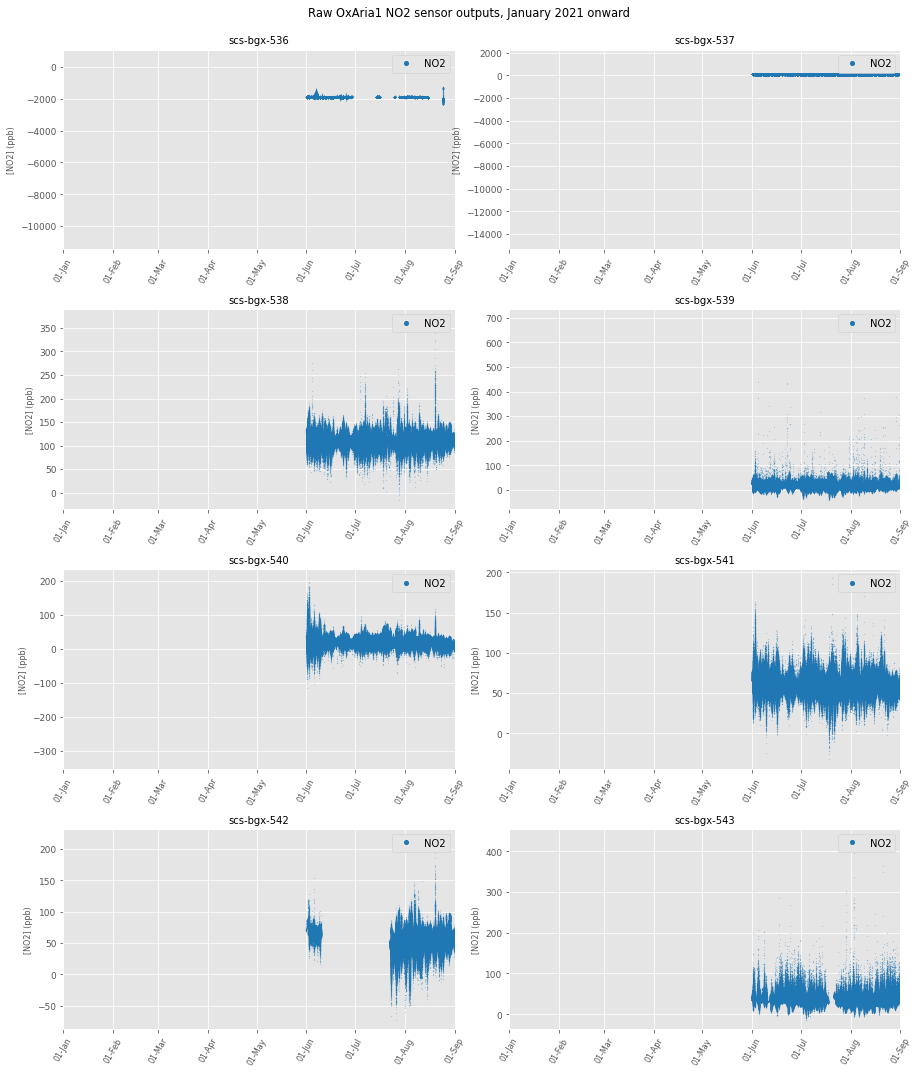

In [8]:
# Check on the outliers & start-ups in the filtered dataset
# ----------------------------------------------------------
plt.style.use('ggplot')
myFmt = mdates.DateFormatter('%d-%b')
start_date = dt.datetime(2021, 1, 1)
end_date = dt.datetime(2021, 9, 1)

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False,
                         sharey=False, figsize=(15, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle('Raw OxAria1 NO2 sensor outputs, January 2021 onward',
             fontsize=11.5, y=0.91)

for tag, dat in oxaria1_gases_lt1.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0, inplace=True)
    dat.plot(y='val.no2.cnc', c='tab:blue', linewidth=0.5, marker='o', ms=0.1, ls='', label='NO2', ax=ax, legend=True,
             zorder=1)
    ax.set_title(tag, fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=60,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0)
    ax.xaxis.set_major_formatter(myFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[NO2] (ppb)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.3)
    ax.legend(markerscale=40, frameon=True, framealpha=0.99, loc='upper right')

plt.show()

for ax in axes_list:
    ax.remove()

In [9]:
oxaria1_gases_lt1

val.no2.wev  val.no2.cnc  val.no2.aev  \
tag         rec                                                                
scs-bgx-536 2021-06-01 00:00:06+00:00      0.28582 -1884.800049      0.27213   
            2021-06-01 00:00:16+00:00      0.28575 -1885.099976      0.27213   
            2021-06-01 00:00:26+00:00      0.28557 -1885.500000      0.27207   
            2021-06-01 00:00:36+00:00      0.28544 -1885.500000      0.27200   
            2021-06-01 00:00:46+00:00      0.28525 -1885.900024      0.27194   
...                                            ...          ...          ...   
scs-bgx-542 2021-09-30 23:59:19+00:00      0.28750    54.799999      0.28857   
            2021-09-30 23:59:29+00:00      0.28732    54.400002      0.28850   
            2021-09-30 23:59:39+00:00      0.28732    54.400002      0.28850   
            2021-09-30 23:59:49+00:00      0.28757    57.299999      0.28832   
            2021-09-30 23:59:59+00:00      0.28732    55.000000      0.28844   

                                       val.no2.wec  val.sht.hmd  val.sht.tmp  \
tag         rec                                                                
scs-bgx-536 2021-06-01 00:00:06+00:00      0.00004    54.599998         18.6   
            2021-06-01 00:00:16+00:00     -0.00002    54.700001         18.6   
            2021-06-01 00:00:26+00:00     -0.00010    54.700001         18.6   
            2021-06-01 00:00:36+00:00     -0.00011    54.799999         18.6   
            2021-06-01 00:00:46+00:00     -0.00019    54.900002         18.6   
...                                            ...          ...          ...   
scs-bgx-542 2021-09-30 23:59:19+00:00     -0.00103    78.300003         18.4   
            2021-09-30 23:59:29+00:00     -0.00111    78.400002         18.4   
            2021-09-30 23:59:39+00:00     -0.00111    78.500000         18.4   
            2021-09-30 23:59:49+00:00     -0.00053    78.400002         18.5   
            2021-09-30 23:59:59+00:00     -0.00100    78.400002         18.4   

                                       exg.vb20.no2.cnc               name  \
tag         rec                                                              
scs-bgx-536 2021-06-01 00:00:06+00:00               4.1            High St   
            2021-06-01 00:00:16+00:00               3.8            High St   
            2021-06-01 00:00:26+00:00               4.2            High St   
            2021-06-01 00:00:36+00:00               4.3            High St   
            2021-06-01 00:00:46+00:00               4.2            High St   
...                                                 ...                ...   
scs-bgx-542 2021-09-30 23:59:19+00:00               4.8  Worcester College   
            2021-09-30 23:59:29+00:00               4.1  Worcester College   
            2021-09-30 23:59:39+00:00               4.1  Worcester College   
            2021-09-30 23:59:49+00:00               5.8  Worcester College   
            2021-09-30 23:59:59+00:00               3.5  Worcester College   

                                       val.no2.cnc_1  
tag         rec                                       
scs-bgx-536 2021-06-01 00:00:06+00:00   -1884.800049  
            2021-06-01 00:00:16+00:00   -1885.099976  
            2021-06-01 00:00:26+00:00   -1885.500000  
            2021-06-01 00:00:36+00:00   -1885.500000  
            2021-06-01 00:00:46+00:00   -1885.900024  
...                                              ...  
scs-bgx-542 2021-09-30 23:59:19+00:00      54.799999  
            2021-09-30 23:59:29+00:00      54.400002  
            2021-09-30 23:59:39+00:00      54.400002  
            2021-09-30 23:59:49+00:00      57.299999  
            2021-09-30 23:59:59+00:00      55.000000  

[6735287 rows x 9 columns]